<a href="https://colab.research.google.com/github/XinZhang0423/machine_learning_tps/blob/main/TP_BasicClassif_NBC_ppv_Appprentis_%E5%B7%B2%E5%86%99%E5%AE%8C%E5%BE%85%E4%BC%98%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/data/"
os.chdir(path)
!ls

Mounted at /content/drive
 column_2C.dat	 iris.data  'UCI HAR Dataset'


# Implémentation de méthodes élémentaires pour la classification supervisée : ADL, ADQ, Naive Bayes et classifieur par plus proches voisins

Pour ce TP, nous aurons besoin des modules Python ci-dessous, il vous faut donc évidemment exécuter cette première cellule.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt

Le jeu de données [Vertebral Column](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column) permet d'étudier les pathologies d'hernie discale et de Spondylolisthesis. Ces deux pathologies sont regroupées dans le jeu de données en une seule catégorie dite `Abnormale`. 

Il s'agit donc d'un problème de classification supervisée à deux classes :
- Normale (NO) 
- Abnormale (AB)    

avec 6 variables bio-mécaniques disponibles (features).

L'objectif du TP est d'implémenter quelques méthodes simples de classification supervisée pour ce problème.

# Importation des données

> Télécharger le fichier column_2C.dat depuis le site de l'UCI à [cette adresse](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column). 
>
> On peut importer les données sous python par exemple avec la librairie [pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html). Vous pourrez au besoin consulter la documentation de la fonction [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). 
> 
> Le chemin donné dans la fonction `read_csv`est une chaîne de caractère qui spécifie le chemin complet vers le ficher sur votre machine. On peut aussi donner une adresse url si le fichier est disponible en ligne.
>
> Attention à la syntaxe pour les chemins sous Windows doit etre de la forme  `C:/truc/machin.csv`. 
> 
> Voir ce [blog](https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f) pour en savoir plus sur la "manipulation des chemins" sur des OS variés. 

In [ ]:
file_path=path+'column_2C.dat'
Vertebral = pd.read_csv(file_path,
                          delim_whitespace= True,
                          header=None)
Vertebral.columns = ["pelvic_incidence",
                                       "pelvic_tilt",
                                       "lumbar_lordosis_angle",
                                       "sacral_slope",
                                       "pelvic_radius",
                                       "degree_spondylolisthesis",
                                       "class"]

> Vérifier à l'aide des méthodes `.head()`  et `describe()` que les données sont bien importées.

In [ ]:
Vertebral.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [ ]:
Vertebral.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


> Les librairies de Machine Learning telles que `sckitlearn` prennent en entrée des tableau numpy (pas des objets pandas). Créer un tableau numpy que vous nommerez `VertebralVar` pour les features et un vecteur numpy `VertebralClas` pour la variable de classe. Voir par exemple [ici](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy).

In [ ]:
VertebralVar  = Vertebral.iloc[:,:-1].to_numpy()
VertebralClas = Vertebral.iloc[:,-1].to_numpy()
print(VertebralVar,VertebralClas)

[[ 63.03  22.55  39.61  40.48  98.67  -0.25]
 [ 39.06  10.06  25.02  29.   114.41   4.56]
 [ 68.83  22.22  50.09  46.61 105.99  -3.53]
 ...
 [ 61.45  22.69  46.17  38.75 125.67  -2.71]
 [ 45.25   8.69  41.58  36.56 118.55   0.21]
 [ 33.84   5.07  36.64  28.77 123.95  -0.2 ]] ['AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB

# Découpage train / test

En apprentissage statistique, classiquement un prédicteur est ajusté sur une partie seulement des données et l'erreur de ce dernier est ensuite évaluée sur une autre partie des données disponibles. Ceci permet de ne pas utiliser les mêmes données pour ajuster et évaluer la qualité d'un prédicteur. Cette problématique est l'objet du prochain chapitre.

> En utilisant la fonction [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) de la librairie [`sklearn.model_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), sélectionner aléatoirement 60% des observations pour l'échantillon d'apprentissage et garder le reste pour l'échantillon de test. 

In [ ]:
from sklearn.model_selection import train_test_split
VertebralVar_train,VertebralVar_test,VertebralClas_train, VertebralClas_test = train_test_split(VertebralVar,VertebralClas,train_size=0.6,shuffle=True)
ntot = VertebralVar_train.shape[0]+VertebralVar_test.shape[0]
ntrain =VertebralVar_train.shape[0]
ntest =VertebralVar_test.shape[0]
print(ntot,ntrain,ntest)

310 186 124


Remarque : on peut aussi le faire à la main avec la fonction [`sklearn.utils.shuffle`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html).

# Extraction des deux classes

> Extraire les deux sous-échantillons de classes respectives "Abnormale" et "Normale" pour les données d'apprentissage et de test.

In [ ]:
VertebralVar_train_AB = VertebralVar_train[VertebralClas_train=='AB']
VertebralVar_train_NO = VertebralVar_train[VertebralClas_train=='NO']
print(VertebralClas_train)

['AB' 'NO' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB'
 'NO' 'NO' 'AB' 'NO' 'AB' 'NO' 'AB' 'NO' 'AB' 'AB' 'AB' 'NO' 'NO' 'NO'
 'AB' 'AB' 'AB' 'NO' 'AB' 'NO' 'AB' 'NO' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB'
 'NO' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'NO' 'AB'
 'NO' 'NO' 'AB' 'AB' 'NO' 'NO' 'AB' 'NO' 'AB' 'NO' 'NO' 'AB' 'NO' 'AB'
 'NO' 'NO' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'NO' 'NO' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'NO' 'NO'
 'AB' 'AB' 'NO' 'AB' 'AB' 'NO' 'NO' 'AB' 'AB' 'AB' 'NO' 'NO' 'AB' 'NO'
 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'NO' 'NO' 'AB' 'AB' 'NO' 'NO' 'AB' 'AB'
 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'NO' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB'
 'AB' 'AB' 'AB' 'AB']


In [ ]:
n_AB = VertebralVar_train_AB.shape[0]
n_NO = VertebralVar_train_NO.shape[0]
print(n_AB)
print(n_NO)

132
54


# Gaussian Naive Bayes

Nous allons ajuster un classifieur naif bayesien sur les données d'apprentissage.

Pour une observation $x \in \mathbb R^6$, la régle du MAP consiste à choisir la catégorie $\hat y (x) = \hat k $ qui maximise (en $k$) 
$$ score_k(x) = \hat \pi_k \prod_{j=1} ^6  \hat f_{k,j}(x_j)   $$
où :
- $k$ est le numéro de la classe ;
- $\hat \pi_k$ est la proportion observée de la classe $k$, 
- $\hat f_{k,j} $ est la densité gaussienne univariée de la classe $k$ pour la variable $j$. Les paramètres de cette loi valent (ajustés par maximum de vraisemblance) :
    - $\hat \mu_{k,j}$ : la moyenne empirique de la variable $X^j$ restreinte à la classe k,
    - $ \hat \sigma^2_{k,j}$ : la variance empirique de la variable $X^j$ restreinte à la classe k.
    
Noter que la fonction $x \mapsto  \prod_{j=1} ^6  f_{k,j}(x_j) $ peut aussi être vue comme une densité gaussienne multidimensionnelle de moyenne $(\mu_{k,1}, \dots, \mu_{k,6})$ et de matrice de covariance diagonale $diag(\hat \sigma^2_{k,1},\dots,\hat  \sigma^2_{k,6})$. Cette remarque évite de devoir calculer le produit de 6 densités univariées, à la place on calcule plus directement la valeur de la densité multidimensionnelle.

Pour calculer la valeur de la densité d'une gaussienne multidimensionnelle en un point $x$ de $\mathbb R ^d$ on peut utililser la fonction [`multivariate_normal`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html) de la librairie [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html). 

On pourra utiliser la fonction `var` de numpy pour calculer le vecteur des variances.

Calcul des moyennes et des variances de chaque variable pour chacun des deux groupes :

In [ ]:
mean_AB = VertebralVar_train_AB.mean(axis=0)
mean_NO = VertebralVar_train_NO.mean(axis=0)

# variances estimées variable par variable pour AB (sur le train) :
var_AB = VertebralVar_train_AB.var(axis=0)
# variances estimées variable par variable pour NO (sur le train) :
var_NO = VertebralVar_train_NO.var(axis=0)

# on forme les matrices de covariance (matrices diagonales car indep) :
Cov_NB_AB = np.diag(var_AB)
Cov_NB_NO = np.diag(var_NO)

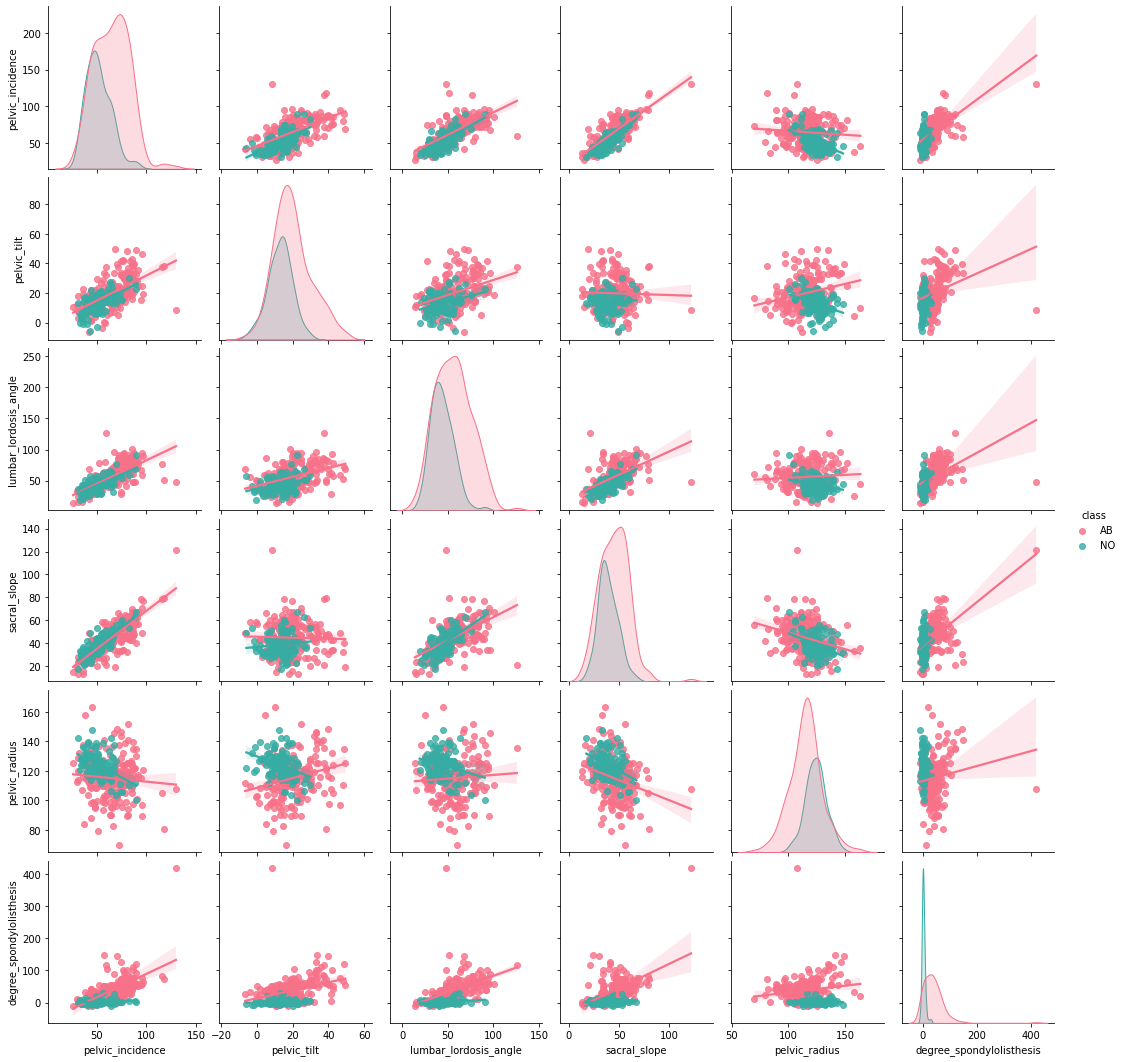

In [ ]:
sns.pairplot(Vertebral,kind="reg",hue='class',diag_kind="kde",palette='husl');

Calcul du "score" sur chaque groupe pour chaque element des données test : 

In [ ]:
score_NB_test=[[n_AB/ntrain*multivariate_normal.pdf(x,mean=mean_AB,cov=Cov_NB_AB),
                n_NO/ntrain*multivariate_normal.pdf(x,mean=mean_NO,cov=Cov_NB_NO)] for x in VertebralVar_test]


In [ ]:
score_NB_test=zip(n_AB/ntrain*multivariate_normal.pdf(VertebralVar_test,mean=mean_AB,cov=Cov_NB_AB),
                  n_NO/ntrain*multivariate_normal.pdf(VertebralVar_test,mean=mean_NO,cov=Cov_NB_NO))

In [ ]:
predict_NB=['AB' if v[0]>v[1] else  'NO' for v in score_NB_test]
print(predict_NB)

['AB', 'NO', 'NO', 'NO', 'AB', 'NO', 'NO', 'NO', 'NO', 'NO', 'AB', 'NO', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'NO', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'NO', 'NO', 'NO', 'AB', 'NO', 'NO', 'AB', 'AB', 'NO', 'NO', 'AB', 'NO', 'AB', 'NO', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'NO', 'NO', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'NO', 'NO', 'NO', 'NO', 'AB', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'AB', 'NO', 'NO', 'NO', 'NO', 'AB', 'NO', 'AB', 'NO', 'AB', 'NO', 'AB', 'AB', 'NO', 'AB', 'AB', 'AB', 'NO', 'NO', 'NO', 'AB', 'NO', 'NO', 'AB', 'NO', 'NO', 'NO', 'NO', 'AB', 'AB', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO', 'AB', 'AB', 'NO', 'NO', 'AB', 'AB', 'AB', 'NO', 'AB']


La matrice de confusion est une matrice qui synthétise les performances d'une régle de classification. Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. La cellule (ligne L, colonne C) contient le nombre d'éléments de la classe réelle L qui ont été estimés comme appartenant à la classe C. Voir par exemple [ici](https://fr.wikipedia.org/wiki/Matrice_de_confusion).

> Evaluer les performances de la méthode sur l'échantillon test. Vous pourrez utiliser la fonction [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) de la librairie [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [ ]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
print(accuracy_score(VertebralClas_test,predict_NB))

0.75


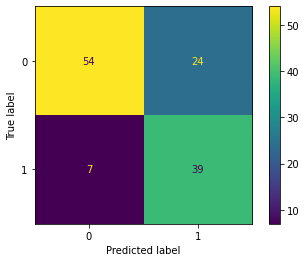

In [ ]:
cnf_matrix_NB_test =  confusion_matrix(VertebralClas_test, predict_NB)
dis=ConfusionMatrixDisplay(cnf_matrix_NB_test)
dis.plot()
plt.show()

>  Il existe bien sûr une fonction scikit-learn  pour la méthode Naive Bayes : voir [ici](http://scikit-learn.org/stable/modules/naive_bayes.html). Vérifier que votre prédicteur donne la même réponse de cette fonction.

0.75


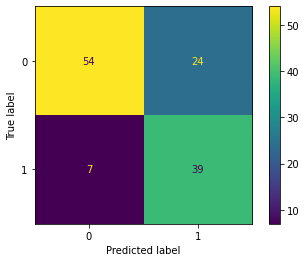

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(VertebralVar_train,VertebralClas_train)
res=gnb.predict(VertebralVar_test)
cnf_matrix_NB_test=confusion_matrix(VertebralClas_test,res)
print(accuracy_score(VertebralClas_test,res))
dis=ConfusionMatrixDisplay(cnf_matrix_NB_test)
dis.plot()
plt.show()

# Classifieur par plus proches voisins

Il est préférable d'utiliser la structure de données de type [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) pour effectuer des requêtes de plus proches voisins dans un nuage de points. 

> Contruction du k-d tree pour les données train (pour la métrique euclidienne) :

In [ ]:
from sklearn.neighbors import KDTree,KNeighborsClassifier
tree = KDTree(VertebralVar_train)

> Rechercher les 10 plus proches voisins dans les données d'apprentissage du premier point des données de test et afficher les classes de ces observations voisines.

In [ ]:
indices_voisins =  tree.query(VertebralVar_train[:1],k=10)[1]
print(indices_voisins)
classes_voisins = VertebralClas_train[indices_voisins]
print(classes_voisins)   

[[  0 168  46 161  40  13 102  41  28  10]]
[['AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB' 'AB']]


Pour le classifieur par plus proches vosins, la prediction est la classe majoritaire des k plus proches voisins.

> Donner la prédiction pour le premier point de test par vote majoritaire sur ses 10 plus proches voisins 

In [ ]:
predict=np.unique(classes_voisins,return_counts=True)
print(predict[0][0])

AB


> Donner la prediction du classifieur ppv pour toutes les données de test. Evaluer la qualité du classifieur.

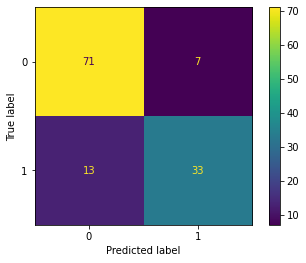

0.8387096774193549
0.75


In [ ]:
k_class =   10 #nombre de plus proche voisins utilisés
knn = KNeighborsClassifier(n_neighbors=k_class ).fit(VertebralVar_train, VertebralClas_train)
pred_kNN_test=knn.predict(VertebralVar_test)
cnf_matrix_kNN=confusion_matrix(VertebralClas_test, pred_kNN_test)
dis=ConfusionMatrixDisplay(cnf_matrix_kNN)
dis.plot()
plt.show()
print(knn.score(VertebralVar_test,VertebralClas_test))
print(accuracy_score(VertebralClas_test,res))

Il existe bien sûr une fonction scikit-learn pour le classifieur plus proche voisin, voir [ici](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).